In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.collection_of_experiments import CollectionOfExperiments
from helpers.plot_helpers import *
from helpers.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord, gaussian_remesh
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import hvplot
hvplot.output(widget_location='bottom')

In [2]:
ds = CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Feb2022/bare', additional_subfolder='output')

In [3]:
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/JansenHeld', additional_subfolder='output')

In [4]:
directory = "/scratch/pp2681/mom6/Apr2023/R4-sensitivity"
for name in os.listdir(directory):
    ds += CollectionOfExperiments.init_folder(os.path.join(directory,name), additional_subfolder='output', prefix=name)

In [5]:
directory = "/scratch/pp2681/mom6/Apr2023/R4-change-range"
for name in os.listdir(directory):
    ds += CollectionOfExperiments.init_folder(os.path.join(directory,name), additional_subfolder='output', prefix=name+'-range')

In [6]:
directory = "/scratch/pp2681/mom6/Apr2023/R4-selected"
for name in os.listdir(directory):
    ds += CollectionOfExperiments.init_folder(os.path.join(directory,name), additional_subfolder='output', prefix=name)

In [7]:
#ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/generalization', additional_subfolder='output')

In [8]:
directory = "/scratch/pp2681/mom6/Apr2023/generalization"
for name in os.listdir(directory):
    ds += CollectionOfExperiments.init_folder(os.path.join(directory,name), additional_subfolder='output', prefix=name)

In [9]:
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2023/GZ21_results', additional_subfolder='')

In [10]:
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/JansenHeld', additional_subfolder='output')

In [11]:
len(ds.exps)

2870

In [12]:
for exp in ds.exps:
    if 'GZ' in exp:
        print(exp)

GZ21-R4
GZ21-R5
GZ21-R6
GZ21-R7
GZ21-R8
R2_GZ-20YEAR_no_scaling
R3_GZ-20YEAR_no_scaling
R4_GZ-20YEAR
R4_GZ-20YEAR_no_scaling
R5_GZ-20YEAR
R5_GZ-20YEAR_no_scaling
R6_GZ-20YEAR
R6_GZ-20YEAR_no_scaling
R7_GZ-20YEAR
R7_GZ-20YEAR_no_scaling
R8_GZ-20YEAR
R8_GZ-20YEAR_no_scaling


In [12]:
for exp in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']:
    ds.remesh('R64', exp)

Experiment R64 coarsegrained to R2 is created. Its identificator=R64_R2
Experiment R64 coarsegrained to R3 is created. Its identificator=R64_R3
Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4
Experiment R64 coarsegrained to R5 is created. Its identificator=R64_R5
Experiment R64 coarsegrained to R6 is created. Its identificator=R64_R6
Experiment R64 coarsegrained to R7 is created. Its identificator=R64_R7
Experiment R64 coarsegrained to R8 is created. Its identificator=R64_R8


# Filtering experiment

In [23]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    ds.remesh('R64', 'R4', 'R64_R4_FGR3', operator= lambda x,y: gaussian_remesh(x,y,FGR=3), compute=True)

[########################################] | 100% Completed | 95.31 s
[########################################] | 100% Completed | 94.47 s
[########################################] | 100% Completed | 134.27 s
[########################################] | 100% Completed | 187.62 s
[########################################] | 100% Completed | 95.21 s
[########################################] | 100% Completed | 94.68 s
[########################################] | 100% Completed | 136.53 s
[########################################] | 100% Completed | 190.27 s
[########################################] | 100% Completed | 95.18 s
[########################################] | 100% Completed | 181.10 s
[########################################] | 100% Completed | 95.26 s
Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4_FGR3


In [24]:
with ProgressBar():
    ds['R64_R4_FGR3'].SGS_transfer

[########################################] | 100% Completed | 262.09 s
[########################################] | 100% Completed | 258.22 s
[########################################] | 100% Completed | 259.99 s
[########################################] | 100% Completed | 256.75 s
[########################################] | 100% Completed | 2.11 sms
[########################################] | 100% Completed | 413.12 ms
[########################################] | 100% Completed | 412.55 ms
[########################################] | 100% Completed | 5.21 sms
[########################################] | 100% Completed | 5.25 sms


In [25]:
dataset = xr.Dataset()
for key in ['u', 'v', 'e', 'h', 'RV', 'RV_f', 'PV', 'SGSx', 'SGSy']:
    dataset[key] = ds['R64_R4_FGR3'].__getattribute__(key)
dataset.to_netcdf('/scratch/pp2681/mom6/R64_R4_FGR3-part1.nc')

In [26]:
dataset = xr.Dataset()
for key in ['ua', 'va', 'ea', 'ha']:
    dataset[key] = ds['R64_R4_FGR3'].__getattribute__(key)
dataset.to_netcdf('/scratch/pp2681/mom6/R64_R4_FGR3-part2.nc')

# Reading filtered experiment

In [21]:
FGR=2.5
ds.remesh('R64', 'R4', f'R64_R4_FGR{FGR}', operator= lambda x,y: gaussian_remesh(x,y,FGR=FGR))
for file in [f'/scratch/pp2681/mom6/R64_R4_FGR{FGR}-part1.nc', f'/scratch/pp2681/mom6/R64_R4_FGR{FGR}-part2.nc']:
    dataset = xr.open_dataset(file, decode_times=False)
    for key in dataset.keys():
        setattr(ds[f'R64_R4_FGR{FGR}'], key, dataset[key])

Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4_FGR2.5


# Figure 1. Grid convergence and domain.

Cannot set letter a
Colorbar-like object skipped


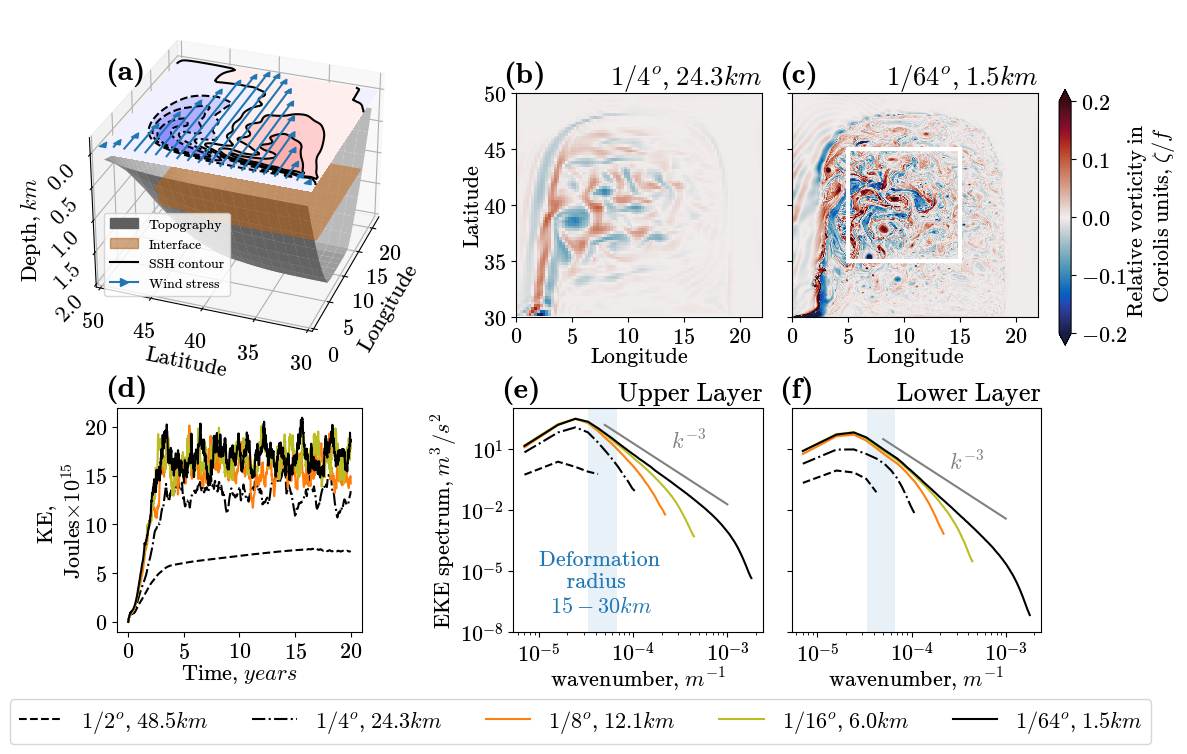

In [15]:
default_rcParams({'font.size': 16,'axes.formatter.limits': (-2,4), 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.4})
from matplotlib.patches import Rectangle
fig = plt.figure(figsize=(12,7))
exps =['R2', 'R4', 'R8', 'R16', 'R64']
labels=['$1/2^o$, $48.5km$', '$1/4^o$, $24.3km$', '$1/8^o$, $12.1km$', '$1/16^o$, $6.0km$', '$1/64^o$, $1.5km$']
colors = ['k', 'k', 'tab:orange', 'tab:olive', 'k']
lss = ['--', '-.', '-', '-', '-']
def plot_spectrum(zl=0):
    for exp,label,color,ls in zip(exps,labels,colors,lss):
        ds[exp].EKE_spectrum.isel(zl=zl).plot(label=label,color=color,ls=ls)
    plt.xlabel(r'wavenumber, $m^{-1}$')
    plt.ylabel('EKE spectrum, $m^3/s^2$')
    if zl==0:
        k = [5e-5, 1e-3]
        E = [1.5e+2, 0]
        plt.text(2.5e-4,1e+1,'$k^{-3}$',color='gray')
    else:
        k = [5e-5, 1e-3]
        E = [3e+1, 0]
        plt.text(2.5e-4,1e0,'$k^{-3}$',color='gray')
    E[1] = E[0] * (k[1]/k[0])**(-3)
    plt.loglog(k,E,ls='-', color='gray')
    plt.title('')
    plt.ylim([1e-8,1e+3])
    
def plot_vorticity(exp):
    field = ds[exp].RV_f.isel(zl=0,Time=-1)
    if exp=='R64':
        field = field.coarsen(xq=2,yq=2,boundary='trim').mean().compute()
    im = field.plot.imshow(vmin=-0.2, vmax=0.2, cmap=cmocean.cm.balance, add_colorbar=False, interpolation='none')
    plt.xticks([0,5,10,15,20])
    plt.yticks([30,35,40,45,50])
    plt.xlim([0,22])
    plt.ylim([30,50])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('')
    plt.gca().set_aspect(1)
    return im

#ax = fig.add_subplot(2,3,1,projection='3d')
ax = fig.add_axes([0.0, 0.5, 0.45, 0.5], projection='3d')
ds.plot_domain(ax)
#plt.title('Double Gyre \nconfiguration')

#ax = fig.add_subplot(2,3,2); plt.sca(ax)
ax = fig.add_axes([0.4, 0.56, 0.32, 0.32]); plt.sca(ax)
plot_vorticity('R4')
plt.title(labels[1],loc='right')

#ax = fig.add_subplot(2,3,3); plt.sca(ax)
ax = fig.add_axes([0.63, 0.56, 0.32, 0.32]); plt.sca(ax)
im = plot_vorticity('R64')
plt.ylabel('')
plt.yticks([30,35,40,45,50], [None]*5)
plt.title(labels[-1],loc='right')
rect = Rectangle((5, 35), 10, 10, linewidth=3, edgecolor='white', facecolor='none')
ax.add_patch(rect)

cax = fig.add_axes([0.91, 0.52, 0.01, 0.365])
plt.colorbar(im, cax=cax, extend='both', label='Relative vorticity in \n Coriolis units, $\zeta/f$')

ax = fig.add_subplot(2,3,4); plt.sca(ax)
for exp,label,color,ls in zip(exps,labels,colors,lss):
    En = (1e-15*ds[exp].series.KE.sum(dim='Layer'))
    En['Time'] = En['Time'] / 365
    En.plot(label=label, color=color,ls=ls)
plt.ylabel('KE, \nJoules$\\times10^{15}$')
plt.xlabel('Time, $years$')
plt.xticks([0,5,10,15,20])

#ax = fig.add_subplot(2,3,5)
ax = fig.add_axes([0.455, 0.11, 0.208, 0.32]); plt.sca(ax)
plot_spectrum(zl=0)
# Baroclinic deformation radius
Rd1 = 30000
Rd2 = 15000
plt.axvspan(1/Rd1, 1/Rd2, color='tab:blue', alpha=0.1, lw=0)
plt.text(1e-5,1e-7,'Deformation \n     radius \n  $15-30km$', fontsize=16, color='tab:blue')
plt.title('Upper Layer', loc='right')
plt.legend(ncol=5, bbox_to_anchor=(2.6,-0.25))

#ax = fig.add_subplot(2,3,6)
ax = fig.add_axes([0.687, 0.11, 0.208, 0.32]); plt.sca(ax)
plot_spectrum(zl=1)
plt.axvspan(1/Rd1, 1/Rd2, color='tab:blue', alpha=0.1, lw=0)
plt.title('Lower Layer', loc='right')
plt.ylabel('')
plt.yticks([1e-8, 1e-5, 1e-2, 1e+1], [None]*4)

set_letters(x=-0.05, y=1.05, fontsize=20, letters=['a', 'b', 'c', 'd', 'e', 'f'])
fig.text(0.115,0.9,'(a)', fontweight='bold',fontsize=20);
plt.savefig('Paper-Figures/DoubleGyre-update-gray.pdf')

# Defining main models for comparison

In [22]:
coarse = 'R4'
hires = 'R64'
hires_bar = 'R64_R4'
ZB = 'ZB-clean-Cs-0.06-ZB-0.5'
JansenHeld = 'Jansen-Held-R4-ref';
ZB_smooth = 'ZB-stress-pass-4-sel-1-Cs-0.06-ZB-1.0'
ZB_reynolds = 'ZB-Reynolds-pass-4-pass-4-Cs-0.06-ZB-2.0'
GZ = 'R4_GZ-20YEAR'

In [33]:
labeling = {
'coarse': '$1/4^o$',
'hires': '$1/64^o$',
'hires_bar': '$1/64^o$-Coarse',
'ZB': '$1/4^o$, ZB20',
'JansenHeld': '$1/4^o$, JH15',
'ZB_smooth': '$1/4^o$, ZB20-Smooth',
'ZB_reynolds': '$1/4^o$, ZB20-Reynolds',
'GZ': '$1/4^o$, GZ21'
}

In [34]:
yellow = [0.9290, 0.6940, 0.1250]
violet = [0.4940, 0.1840, 0.5560]
lightblue = [0.3010, 0.7450, 0.9330]

# Figure 2. EKE spectrum

In [35]:
exps = [ JansenHeld, GZ, ZB, ZB_smooth, ZB_reynolds, coarse, hires]
labels = [labeling[key] for key in ['JansenHeld', 'GZ', 'ZB', 'ZB_smooth', 'ZB_reynolds', 'coarse', 'hires']]
colors = ['tab:red', 'tab:green', 'tab:blue', yellow, violet, 'k', 'k']
lws = [2.0]*5 + [1.5, 1.5]
lss = [ '--', '-.', '-', '-', '-', '-.', '-']
zorders = [None]*6 + [-1]

In [36]:
def plot_spectrum(zl=0):
    for exp,label,color,lw,ls,zorder in zip(exps,labels,colors,lws,lss,zorders):
        ds[exp].EKE_spectrum.isel(zl=zl).plot(label=label,color=color,lw=lw,ls=ls,zorder=zorder)
    plt.xlabel(r'wavenumber, $m^{-1}$')
    plt.ylabel('EKE spectrum, $m^3/s^2$')
    if zl==0:
        k = [5e-5, 5e-4]
        E = [1.5e+2, 0]
        plt.text(1.5e-4,2e+1,'$k^{-3}$',color='gray')
    else:
        k = [5e-5, 5e-4]
        E = [3e+1, 0]
        plt.text(1.5e-4,2e0,'$k^{-3}$',color='gray')
    E[1] = E[0] * (k[1]/k[0])**(-3)
    plt.loglog(k,E,ls='-',color='gray')
    plt.title('')
    plt.ylim([1e-5,1e+3])
    plt.xlim([None,1e-3])

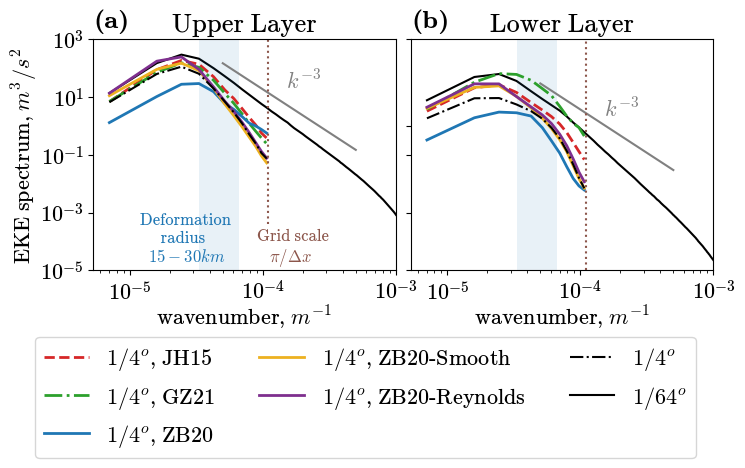

In [37]:
default_rcParams({'font.size': 16, 'figure.subplot.wspace': 0.05})
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plot_spectrum()
plt.title('Upper Layer')
plt.legend(ncol=3, bbox_to_anchor=(0.9,-0.55), loc='center')
# Baroclinic deformation radius
Rd1 = 30000
Rd2 = 15000
plt.axvspan(1/Rd1, 1/Rd2, color='tab:blue', alpha=0.1, lw=0)
plt.text(1.2e-5,2e-5,'Deformation \n     radius \n  $15-30km$', fontsize=12, color='tab:blue')
plt.axvline(x=1.1e-4, ls=':', color='tab:brown', ymin=0.2)
plt.text(0.9e-4, 0.2e-4, 'Grid scale\n   $\\pi/\\Delta x$', fontsize=12, color='tab:brown')
plt.subplot(1,2,2)
plot_spectrum(zl=1)
plt.title('Lower Layer')
set_letters(y = 1.05, x=0, fontsize=18)
plt.axvspan(1/Rd1, 1/Rd2, color='tab:blue', alpha=0.1, lw=0)
plt.axvline(x=1.1e-4, ls=':', color='tab:brown', ymin=0.0)
plt.ylabel('')
plt.yticks([1e-5, 1e-3, 1e-1, 1e0, 1e+3], [None]*5);
plt.savefig('Paper-Figures/Spectrum-GZ-20.pdf')

# Figure 3. Offline vs Online transfer spectrum.

In [38]:
ref = ds['R64_R4_FGR2.5']
SGS = ref.SGS_transfer
ZB_offline = ref.transfer(*ref.ZB_offline(amplitude=0.5)).compute()
ZB_smooth_offline = ref.transfer(*ref.ZB_offline(amplitude=1.0, Stress_iter=4)).compute()
ZB_reynolds_offline = ref.transfer(*ref.ZB_offline(amplitude=2.0, Stress_iter=4, HPF_iter=4)).compute()

In [39]:
gz = xr.concat([xr.open_dataset('/scratch/pp2681/mom6/Apr2023/GZ_offline/GZ21_zl0.nc',
                decode_times=False), xr.open_dataset('/scratch/pp2681/mom6/Apr2023/GZ_offline/GZ21_zl1.nc',
                decode_times=False)], 'zl').rename({'time': 'Time'})
scaling = 0.7827
GZ_offline = ref.transfer(scaling * gz.S_x, scaling * gz.S_y).compute()

In [40]:
Smagorinsky_offline = ref.transfer(*ref.Smagorinsky(Cs=0.06)).compute()

In [41]:
def compensated(sp):
    return sp * sp.freq_r

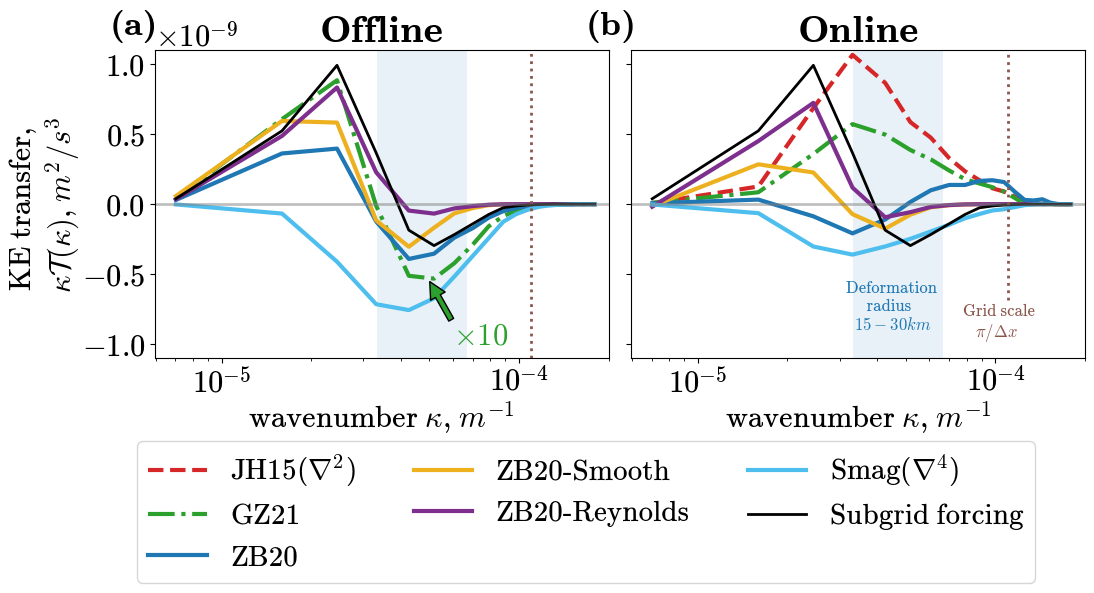

In [42]:
labels = ['ZB20', 'ZB20-Smooth', 'ZB20-Reynolds']
colors = ['tab:blue', yellow, violet]

default_rcParams({'font.size':22, 'figure.subplot.wspace': 0.05})
zl=0
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
compensated(GZ_offline*10).isel(zl=zl).plot(lw=3, color='tab:green', ls='-.')
compensated(ZB_offline).isel(zl=zl).plot(lw=3, color=colors[0])
compensated(ZB_smooth_offline).isel(zl=zl).plot(lw=3, color=colors[1])
compensated(ZB_reynolds_offline).isel(zl=zl).plot(lw=3, color=colors[2])
compensated(Smagorinsky_offline).isel(zl=zl).plot(lw=3, color=lightblue)
compensated(SGS).isel(zl=zl).plot(color='k', lw=2)
plt.axhline(y=0,color='gray', alpha=0.5, lw=2)
plt.xlabel('wavenumber $\kappa$, $m^{-1}$')
plt.ylabel('KE transfer, \n$\kappa \mathcal{T}(\kappa)$, $m^2/s^3$')
plt.title('Offline', fontweight='bold', y=1.)
Rd1 = 30000
Rd2 = 15000
plt.axvspan(1/Rd1, 1/Rd2, color='tab:blue', alpha=0.1, lw=0)
plt.ylim([-1.1e-9,1.1e-9])
plt.yticks(np.linspace(-1e-9,1e-9,5))
plt.xscale('log')
plt.axvline(x=1.1e-4, ls=':', color='tab:brown', lw=2)
plt.xlim([None, 2e-4])

plt.gca().annotate('$\\times 10$', color='tab:green', xy=(5e-5, -0.55e-9), xytext=(6e-5,-1e-9),
                arrowprops=dict(facecolor='tab:green', shrink=0.01))

plt.subplot(1,2,2)
lss = ['-','-','-']
compensated(ds['Jansen-Held-R4-backscatter-data-ref'].JH_transfer).isel(zl=zl).plot(lw=3, label='JH15($\\nabla^2$)', color='tab:red', ls='--')
compensated(ds[GZ].GZ_transfer).isel(zl=zl).plot(lw=3, label='GZ21', color='tab:green', ls='-.')
for exp,label,color,ls in zip([ZB, ZB_smooth, ZB_reynolds],labels,colors,lss):
    compensated(ds[exp].ZB_transfer).isel(zl=zl).plot(lw=3, label=label,color=color,ls=ls)
compensated(ds['R4'].Model_transfer).isel(zl=zl).plot(lw=3, label='Smag($\\nabla^4$)', color=lightblue)
compensated(SGS).isel(zl=zl).plot(color='k', lw=2, label='Subgrid forcing')
plt.axhline(y=0,color='gray', alpha=0.5, lw=2)
plt.xlabel('wavenumber $\kappa$, $m^{-1}$')
plt.ylim([-1.1e-9,1.1e-9])
plt.yticks(np.linspace(-1e-9,1e-9,5), [None]*5)
plt.xscale('log')
plt.xlim([None, 2e-4])
plt.title('Online', fontweight='bold', y=1.)
plt.legend(bbox_to_anchor=(-0.1,-0.5), loc='center', ncol=3, fontsize=21)
plt.axvspan(1/Rd1, 1/Rd2, color='tab:blue', alpha=0.1, lw=0)
plt.text(3.15e-5,-0.9e-9,'Deformation \n     radius \n  $15-30km$', fontsize=12, color='tab:blue')
plt.axvline(x=1.1e-4, ls=':', color='tab:brown', ymin=0.19, lw=2)
plt.text(0.78e-4, -0.95e-9, 'Grid scale\n   $\\pi/\\Delta x$', fontsize=12, color='tab:brown')

set_letters(fontsize=24, x=-0.1)

plt.savefig('Paper-Figures/SGS_spectrum-GZ-20.pdf')

# Figure 4. Energy distribution.

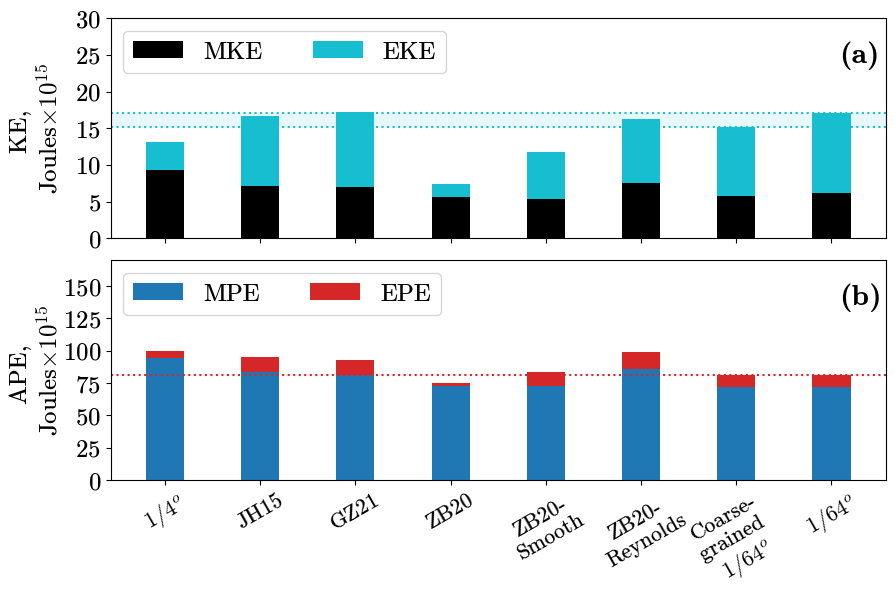

In [45]:
exps = [coarse, JansenHeld, GZ, ZB, ZB_smooth, ZB_reynolds, 'R64_R4', 'R64']
labels = ['$1/4^o$', 'JH15', 'GZ21', 'ZB20', 'ZB20-\nSmooth', 'ZB20-\nReynolds', 'Coarse-\ngrained \n$1/64^o$', '$1/64^o$']

default_rcParams({'font.size':18})
ds.plot_KE_PE_simpler(exps, labels, rotation=30)
set_letters(y=0.8, x=0.94, fontsize=20)
plt.gcf().align_ylabels() 

plt.savefig('Paper-Figures/KE_PE-GZ-20.pdf')

# Figure 5. Bias in SSH.

In [47]:
def plot_ssh(exp, x=True, y=True, target='R64_R4'):
    ssh = ds[exp].ssh_mean
    print(float(ssh.min()), float(ssh.max()))
    levels = np.arange(-4,4.5,0.5)
    im = ssh.plot.contourf(levels=levels, cmap='bwr', linewidths=1, vmin=-4, vmax=4, add_colorbar=False)#, cbar_kwargs={'label': 'SSH, $m$', 'ticks': [-4,-3,-2,-1,0,1,2,3,4]})
    Cplot = ssh.plot.contour(levels=levels, colors='k', linewidths=1)
    plt.gca().clabel(Cplot, Cplot.levels)
    if x:
        plt.xticks((0, 5, 10, 15, 20))
        plt.xlabel('Longitude')
    else:
        plt.xticks([])
        plt.xlabel('')
        
    if y:
        plt.yticks((30, 35, 40, 45, 50))
        plt.ylabel('Latitude')
    else:
        plt.yticks([])
        plt.ylabel('')
    plt.title('')
    if exp != target:
        RMSE = Lk_error(ds[exp].ssh_mean,ds[target].ssh_mean)[0]
        plt.text(8.5,31,'RMSE='+"{:.3f}".format(RMSE)+'$m$', fontsize=13)
    
    plt.gca().set_aspect(1)
    
    return im
def plot_error(exp, target=hires_bar):
    ssh = ds[exp].ssh_mean
    ssh = ssh - remesh(ds[target].ssh_mean,ssh)
    print(float(ssh.min()), float(ssh.max()))
    levels = np.linspace(-3,3,31)
    ssh.plot.contourf(levels=levels, cmap='bwr', linewidths=1, vmin=-3, vmax=3, cbar_kwargs={'label': 'SSH error, $m$', 'ticks': [-3,-2,-1,0,1,2,3]})
    plt.xticks((0, 5, 10, 15, 20))
    plt.yticks((30, 35, 40, 45, 50))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('')

-1.8932974338531494 1.4127191305160522
-2.3586008548736572 3.1677963733673096
-2.25085186958313 2.0608599185943604
-2.106016159057617 2.313742160797119
-2.3523244857788086 1.3881415128707886
-2.003835678100586 1.3600364923477173
-2.200723886489868 2.2309136390686035
Colorbar-like object skipped


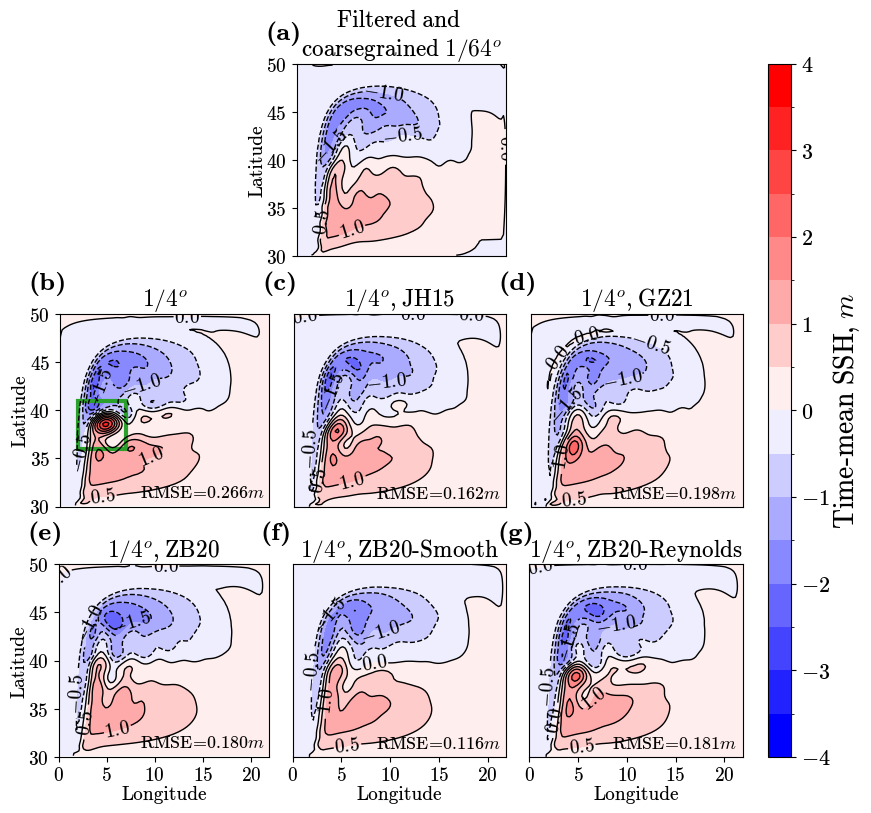

In [52]:
from matplotlib.patches import Rectangle
default_rcParams({'font.size': 14, 'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.3})
plt.figure(figsize = (11,9))

target = 'R64_R4_FGR2.5'
plt.subplot(3,3,2)
im=plot_ssh(target,x=False, target=target)
plt.title('Filtered and \ncoarsegrained $1/64^o$')

plt.subplot(3,3,4)
plot_ssh(coarse, x=False, target=target)
plt.title(labeling['coarse'])
rect = Rectangle((2, 36), 5, 5, linewidth=3, edgecolor='tab:green', facecolor='none')
plt.gca().add_patch(rect)

plt.subplot(3,3,5)
plot_ssh(JansenHeld,x=False,y=False, target=target)
plt.title(labeling['JansenHeld'])

plt.subplot(3,3,6)
plot_ssh(GZ,x=False,y=False, target=target)
plt.title(labeling['GZ'])

plt.subplot(3,3,7)
plot_ssh(ZB,  target=target)
plt.title(labeling['ZB'])

plt.subplot(3,3,8)
plot_ssh(ZB_smooth,y=False, target=target)
plt.title(labeling['ZB_smooth'])
plt.xlabel('Longitude')

plt.subplot(3,3,9)
plot_ssh(ZB_reynolds,y=False, target=target)
plt.title(labeling['ZB_reynolds'])
plt.xlabel('Longitude')

cb = plt.colorbar(im, ax=plt.gcf().axes, pad=0.03, aspect=30)
cb.ax.tick_params(labelsize=16)
cb.set_label(label='Time-mean SSH, $m$', fontsize=20)

set_letters(fontsize=18, y=1.13,x=-0.15)

plt.savefig('Paper-Figures/ssh-GZ_filtered-20.pdf')

# Figure 6. Zonal acceleration.

In [53]:
def plot_accel(exp, x=True, y=True, vmax=1.5, zonal=True, zl=0, resolved='False'):
    accel = lambda x: 1e+7*x.sel(Time=slice(365*10,None)).mean('Time').isel(zl=zl).compute()
    
    if '_R' in exp:
        if zonal:
            field = ds[exp].SGSx
            field.loc[{'xq': slice(0,5), 'yh': slice(48,50)}] = 0.
        else:
            field = ds[exp].SGSy
            field.loc[{'xh': slice(0,5), 'yq': slice(48,50)}] = 0.
    elif 'GZ' in exp:
        if zonal:
            field = ds[exp].mom.CNNu+ds[exp].mom.diffu
        else:
            field = ds[exp].mom.CNNv+ds[exp].mom.diffv
    else:
        if zonal:
            field = ds[exp].mom.diffu
        else:
            field = ds[exp].mom.diffv
            
    if resolved == 'True':
        field = ds[exp].advection[0]
    elif resolved == 'joint':
        field = field + ds[exp].advection[0]
            
    acceleration = accel(field)
    
    print(float(acceleration.min()),float(acceleration.max()))
    im = acceleration.plot.imshow(vmin=-vmax, vmax=vmax, add_colorbar=False, cmap='seismic', interpolation='none')

    if x:
        plt.xticks((0, 5, 10, 15, 20))
        plt.xlabel('Longitude')
    else:
        plt.xticks([])
        plt.xlabel('')
        
    if y:
        plt.yticks((30, 35, 40, 45, 50))
        plt.ylabel('Latitude')
    else:
        plt.yticks([])
        plt.ylabel('')
    plt.title('')    
    plt.gca().set_aspect(1)
    
    return im

-8.378390357616551 4.449274736397129
-4.87225341796875 6.93408203125
-4.993709087371826 7.517899513244629
-8.812776565551758 8.217284202575684
-8.3770170211792 5.107608795166016
-7.559136867523193 2.3394572734832764
-10.127265930175781 3.883437156677246
Colorbar-like object skipped


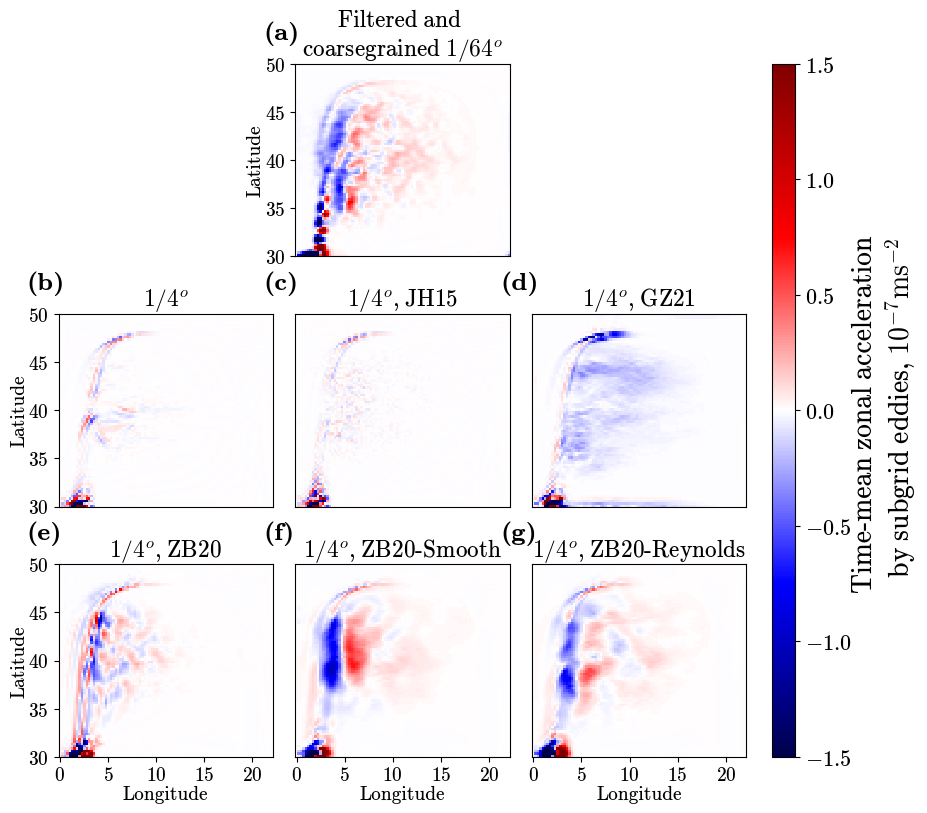

In [54]:
from matplotlib.patches import Rectangle
default_rcParams({'font.size': 14, 'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.3})
plt.figure(figsize = (11,9))

plt.subplot(3,3,2)
im=plot_accel('R64_R4_FGR2.5',x=False)
plt.title('Filtered and \ncoarsegrained $1/64^o$')

#plt.subplot(3,3,2)
#im=plot_accel('R64_R4',x=False, y=False)
#plt.title('coarsegrained $1/64^o$')

#plt.subplot(3,3,3)
#im=plot_accel('R64_R4_FGR2.5',x=False,y=False,resolved=True)
#plt.title('Resolved $1/64^o$')


plt.subplot(3,3,4)
plot_accel(coarse, x=False)
plt.title(labeling['coarse'])
rect = Rectangle((2, 36), 5, 5, linewidth=3, edgecolor='tab:green', facecolor='none')
#plt.gca().add_patch(rect)

plt.subplot(3,3,5)
plot_accel(JansenHeld,x=False,y=False)
plt.title(labeling['JansenHeld'])

plt.subplot(3,3,6)
plot_accel(GZ,x=False,y=False)
plt.title(labeling['GZ'])

plt.subplot(3,3,7)
plot_accel(ZB)
plt.title(labeling['ZB'])

plt.subplot(3,3,8)
plot_accel(ZB_smooth,y=False)
plt.title(labeling['ZB_smooth'])
plt.xlabel('Longitude')

plt.subplot(3,3,9)
plot_accel(ZB_reynolds,y=False)
plt.title(labeling['ZB_reynolds'])
plt.xlabel('Longitude')

cb = plt.colorbar(im, ax=plt.gcf().axes, pad=0.03, aspect=30)
cb.ax.tick_params(labelsize=16)
cb.set_label(label='Time-mean zonal acceleration \n by subgrid eddies, $10^{-7} \\mathrm{m}\\mathrm{s}^{-2}$', fontsize=20)#, labelpad=5)

set_letters(fontsize=18, y=1.13,x=-0.15)

plt.savefig('Paper-Figures/zonal-acceleration-update-20.pdf')

# Appendix C. Sensitivity to the Smagorinsky coefficient

In [13]:
def error_ssh(exp):
    return Lk_error(ds[exp].ssh_mean,ds['R64_R4'].ssh_mean)[0]

In [19]:
def error_2d(error_function = error_ssh, prefix='ZB-clean'):
    ZBs = sorted([float(exp.split('-')[-1]) for exp in ds.exps if f'{prefix}-Cs-0.03' in exp])
    Css = sorted(set([float(exp.split('-')[-3]) for exp in ds.exps if f'{prefix}-Cs-' in exp]))
    
    error = np.zeros((len(ZBs), len(Css)))
    for i, Cs in enumerate(Css):
        for j, ZB in enumerate(ZBs):
            try:
                error[j,i] = error_function(f'{prefix}-Cs-{Cs:.2f}-ZB-{ZB}')
            except:
                error[j,i] = np.nan
    error = xr.DataArray(error, dims=['ZB', 'Cs'], coords={'Cs': Css, 'ZB': ZBs})
    return error

In [20]:
ssh = {'v0': 0.26709399, 'vmin': 0.0, 'error_function': error_ssh, 
           'cbar_ticks': np.arange(0.0,0.7,0.05), 
           'cbar_extend': 'neither', 'cbar_label': 'RMSE in \ntime-mean SSH, $m$'};

In [21]:
def constrain_optimization(e):
    #shape of e is ZB x Cs
    ee = e.copy()
    for j in range(e.shape[1]):
        for i in range(e.shape[0]):
            if np.isnan(e[i,j]):
                ee[i:,j] = np.nan
    return ee    

In [22]:
def plot_panels(exps, labels, v0, vmin, error_function, color='w', cbar_ticks=None, cbar_extend='none', cbar_label=''):
    default_rcParams({'axes.formatter.limits': (-3,3)})
    fig = plt.figure(figsize=(3*len(exps),4))
    vspread = v0-vmin
    vmax = v0+vspread

    for col in range(len(exps)):
        label=labels[col]
        exp=exps[col]
        plt.subplot(1,len(exps),col+1)
        e = error_2d(error_function = error_function, prefix=exp)
        X,Y = np.meshgrid(e.Cs, e.ZB)
        em = np.ma.masked_invalid(e)
        im = plt.pcolor(X,Y,em,vmin=vmin,vmax=vmax,cmap='RdBu_r')
        # https://stackoverflow.com/questions/35905393/python-leave-numpy-nan-values-from-matplotlib-heatmap-and-its-legend
        plt.gca().patch.set(hatch='OO', edgecolor='black')
        
        #im = e.plot(cmap='RdBu_r', add_colorbar=False, vmin=vmin, vmax=vmax)
        cb = plt.colorbar(im, fraction=0.3, pad=0.05, aspect=15, ticks=cbar_ticks, extend=cbar_extend)
        cb.set_label(cbar_label, fontsize=16, labelpad=10)
        if col<len(exps)-1:
            cb.ax.set_yticklabels(['']*len(cbar_ticks))
            cb.set_label('')
            
        idx_opt = constrain_optimization(e).argmin(dim='ZB')
        if len(e.Cs) == 3:
            markers = ['v', 'o', 's']
        else:
            markers = ['*', 'v', 'o', 's']
        
        for marker, Cs in zip(markers,idx_opt.Cs):
            idx = idx_opt.sel(Cs=Cs)
            plt.plot(Cs,e.ZB[idx], marker=marker, markeredgecolor=color, markerfacecolor='none', markersize=10, markeredgewidth=2, clip_on=False)
            cb.ax.plot(0.5,e.sel(Cs=Cs).isel(ZB=idx),marker=marker,markeredgecolor=color, markerfacecolor='none', markersize=10, markeredgewidth=2)
            plt.plot(Cs,0,marker=marker,markeredgecolor='k', markerfacecolor='none', markersize=7, markeredgewidth=1, clip_on=False)
            cb.ax.plot(0.5,e.sel(ZB=0.0,Cs=Cs),marker=marker,markeredgecolor='k', markerfacecolor='none', markersize=7, markeredgewidth=1)
        
#         for Cs in e.Cs:
#             for ZB in e.ZB:
#                 if np.isnan(e.sel(Cs=Cs,ZB=ZB)):
#                     plt.plot(Cs,ZB,marker='*',color='k')

        plt.xticks(e.Cs.values, rotation=60)
        if len(e.ZB) > 16:
            plt.yticks(e.ZB.values[::2])
        else:
            plt.yticks(e.ZB.values)
            
        plt.xlabel('')
        if col==0:
            plt.ylabel('ZB scaling coefficient, $\gamma$', fontsize=20)
        else:
            plt.ylabel('')
        plt.title(label)
    fig.text(0.5, -0.1, 'Smagorinsky coefficient $C_S$', ha='center', fontsize=20)
    

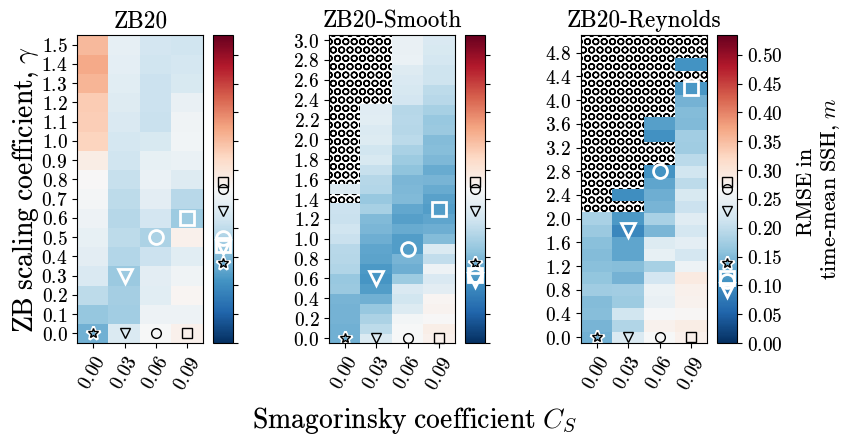

In [23]:
plot_panels(['ZB-clean', 'ZB-stress-pass-4-sel-1', 'ZB-Reynolds-pass-4-pass-4'], ['ZB20','ZB20-Smooth', 'ZB20-Reynolds'], **ssh)
plt.savefig('Paper-Figures/sensitivity-Cs-update-20.pdf')